In [17]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

import joblib
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42

print("Loading processed data...")

# This is what you created and saved in Notebook 1
df = pd.read_csv('../Data/processed/provider_features_final.csv')

# Target: PotentialFraud -> binary
y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})

# Features: drop ID + target
X = df.drop(['Provider', 'PotentialFraud'], axis=1)

# If FraudBinary is still in the file, drop it (was helper column)
if 'FraudBinary' in X.columns:
    print("Dropping helper column 'FraudBinary' from features")
    X = X.drop('FraudBinary', axis=1)

print("Data loaded!")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Recreate the same split as Notebook 2
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print("\nTrain/Val/Test sizes:")
print("  Train:", len(X_train))
print("  Val:  ", len(X_val))
print("  Test: ", len(X_test))

# Load scaler, feature names, and final model
scaler = joblib.load('../models/scaler.joblib')
feature_names = joblib.load('../models/feature_names.joblib')

# Scale test set
X_test_scaled = scaler.transform(X_test)

# IMPORTANT: use the same model you used in Notebook 2
# (you loaded '../models/logistic_regression_model.joblib' there)
best_model = joblib.load('../models/logistic_regression_model.joblib')
print("\nLoaded final model:")
print(best_model)


Loading processed data...
Dropping helper column 'FraudBinary' from features
Data loaded!
X shape: (5410, 23)
y shape: (5410,)

Train/Val/Test sizes:
  Train: 3787
  Val:   811
  Test:  812

Loaded final model:
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')


In [18]:
# %%
# Predictions
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    # For models without predict_proba
    y_proba = best_model.decision_function(X_test_scaled)

y_pred = best_model.predict(X_test_scaled)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"],
    "Score": [acc, prec, rec, f1, roc_auc, pr_auc]
})

print("Final Test-Set Metrics:\n")
display(metrics_df)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=["Non-Fraud", "Fraud"]))


Final Test-Set Metrics:



,Metric,Score
0,Accuracy,0.875616
1,Precision,0.417219
2,Recall,0.828947
3,F1-Score,0.555066
4,ROC-AUC,0.933031
5,PR-AUC,0.684242



Classification Report (Test Set):
              precision    recall  f1-score   support

   Non-Fraud       0.98      0.88      0.93       736
       Fraud       0.42      0.83      0.56        76

    accuracy                           0.88       812
   macro avg       0.70      0.85      0.74       812
weighted avg       0.93      0.88      0.89       812



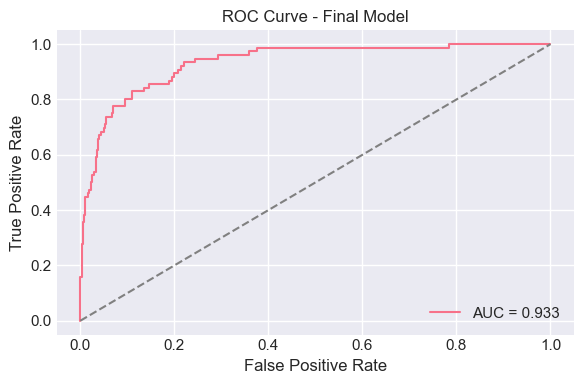

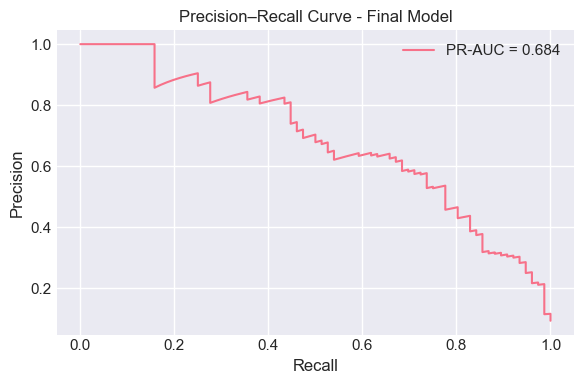

In [20]:
# %%
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Model")
plt.legend()
plt.tight_layout()
plt.show()

# Precision–Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f"PR-AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Final Model")
plt.legend()
plt.tight_layout()
plt.show()


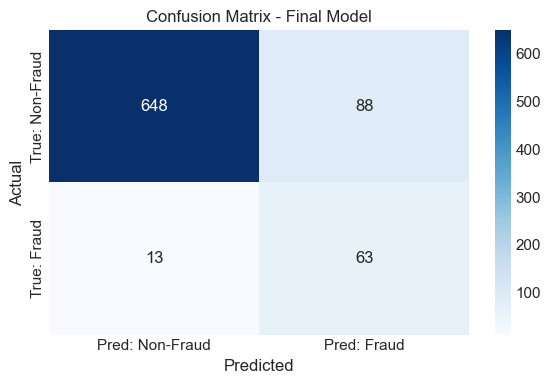

TN = 648, FP = 88, FN = 13, TP = 63

Fraud detection rate (Recall): 82.9%
False positive rate among non-fraud: 12.0%


In [21]:
# %%
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Non-Fraud", "Pred: Fraud"],
            yticklabels=["True: Non-Fraud", "True: Fraud"])
plt.title("Confusion Matrix - Final Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

print(f"TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}")
print(f"\nFraud detection rate (Recall): {rec:.1%}")
print(f"False positive rate among non-fraud: {fp / (fp + tn):.1%}")


In [22]:
# %%
# Simple cost model (you can adjust these numbers)
avg_fraud_amount = 50000   # assumed average loss per fraudulent provider
investigation_cost = 1000  # assumed cost per investigation (false positive)

total_fraud = tp + fn
detected_fraud = tp
missed_fraud = fn

fraud_prevented = detected_fraud * avg_fraud_amount
fraud_missed = missed_fraud * avg_fraud_amount
false_positive_costs = fp * investigation_cost

print("\nCost-Based Analysis (Test Set):")
print(f"  Total fraud providers:           {total_fraud}")
print(f"  Detected fraud (TP):             {detected_fraud} ({detected_fraud/total_fraud:.1%})")
print(f"  Missed fraud (FN):               {missed_fraud} ({missed_fraud/total_fraud:.1%})")
print(f"  Fraud prevented (savings):       ${fraud_prevented:,.0f}")
print(f"  Fraud missed (loss):             ${fraud_missed:,.0f}")
print(f"  Investigation costs (FP):        ${false_positive_costs:,.0f}")
print(f"  Net benefit (savings - FP cost): ${fraud_prevented - false_positive_costs:,.0f}")



Cost-Based Analysis (Test Set):
  Total fraud providers:           76
  Detected fraud (TP):             63 (82.9%)
  Missed fraud (FN):               13 (17.1%)
  Fraud prevented (savings):       $3,150,000
  Fraud missed (loss):             $650,000
  Investigation costs (FP):        $88,000
  Net benefit (savings - FP cost): $3,062,000


In [23]:
# %%
# Build error dataframe on original feature scale (X_test, not scaled)
errors = pd.DataFrame(X_test, columns=X.columns)
errors['y_true'] = y_test.values
errors['y_pred'] = y_pred
errors['proba_fraud'] = y_proba

false_positives = errors[(errors.y_true == 0) & (errors.y_pred == 1)].copy()
false_negatives = errors[(errors.y_true == 1) & (errors.y_pred == 0)].copy()

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


False Positives: 88
False Negatives: 13


In [24]:
# %%
# Top 3 FP = model very confident they are fraud, but they are actually non-fraud
fp_cases = false_positives.sort_values('proba_fraud', ascending=False).head(3)

# Top 3 FN = model thought probability low enough to predict 0, but they are fraud
fn_cases = false_negatives.sort_values('proba_fraud', ascending=False).head(3)

key_cols_to_show = [
    'InscClaimAmtReimbursed_sum',
    'InscClaimAmtReimbursed_count',
    'DeductibleAmtPaid_sum',
    'Amount_Per_Physician',
    'Inpatient_Outpatient_Ratio',
    'Deductible_Ratio'
]
key_cols_present = [c for c in key_cols_to_show if c in X.columns]

print("\nTop 3 False Positives (legit providers flagged as fraud):")
display(fp_cases[['y_true', 'y_pred', 'proba_fraud'] + key_cols_present])

print("\nTop 3 False Negatives (fraud providers missed):")
display(fn_cases[['y_true', 'y_pred', 'proba_fraud'] + key_cols_present])



Top 3 False Positives (legit providers flagged as fraud):


,y_true,y_pred,proba_fraud,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_count,DeductibleAmtPaid_sum,Amount_Per_Physician,Inpatient_Outpatient_Ratio,Deductible_Ratio
3325,0,1,0.999790,1011760,721,89036.0,2984.542773,0.129890,0.088001
361,0,1,0.999489,1038990,135,117480.0,74213.571429,4.666667,0.113071
5365,0,1,0.997466,688200,860,45868.0,5735.000000,0.051282,0.066649



Top 3 False Negatives (fraud providers missed):


,y_true,y_pred,proba_fraud,InscClaimAmtReimbursed_sum,InscClaimAmtReimbursed_count,DeductibleAmtPaid_sum,Amount_Per_Physician,Inpatient_Outpatient_Ratio,Deductible_Ratio
4956,1,0,0.436020,137020,43,10890.0,4567.333333,0.294118,0.079477
4471,1,0,0.410012,135460,143,17388.0,2882.127660,0.125000,0.128362
3001,1,0,0.315046,87470,80,6538.0,1198.219178,0.094595,0.074745


In [25]:
# %%
print("\nMean of key features for False Positives vs True Negatives:")
if len(false_positives) > 0:
    fp_mean = false_positives[key_cols_present].mean()
    tn_mean = errors[(errors.y_true == 0) & (errors.y_pred == 0)][key_cols_present].mean()
    display(pd.DataFrame({'FP_mean': fp_mean, 'TN_mean': tn_mean, 'FP/TN_ratio': fp_mean / (tn_mean + 1e-9)}))

print("\nMean of key features for False Negatives vs True Positives:")
if len(false_negatives) > 0:
    fn_mean = false_negatives[key_cols_present].mean()
    tp_mean = errors[(errors.y_true == 1) & (errors.y_pred == 1)][key_cols_present].mean()
    display(pd.DataFrame({'FN_mean': fn_mean, 'TP_mean': tp_mean, 'FN/TP_ratio': fn_mean / (tp_mean + 1e-9)}))



Mean of key features for False Positives vs True Negatives:


,FP_mean,TN_mean,FP/TN_ratio
InscClaimAmtReimbursed_sum,273635.795455,25569.120370,10.701807
InscClaimAmtReimbursed_count,250.477273,50.188272,4.990753
DeductibleAmtPaid_sum,21356.409091,1508.154321,14.160626
Amount_Per_Physician,17658.217831,3023.650493,5.840033
Inpatient_Outpatient_Ratio,2.017838,0.336680,5.993347
Deductible_Ratio,0.070611,0.037109,1.902799



Mean of key features for False Negatives vs True Positives:


,FN_mean,TP_mean,FN/TP_ratio
InscClaimAmtReimbursed_sum,77899.230769,793551.428571,0.098165
InscClaimAmtReimbursed_count,111.538462,659.428571,0.169144
DeductibleAmtPaid_sum,5451.076923,65480.984127,0.083247
Amount_Per_Physician,4525.759400,40589.042929,0.111502
Inpatient_Outpatient_Ratio,0.318318,4.519076,0.070439
Deductible_Ratio,0.062654,0.077707,0.806284


In [26]:
# %%
print("Loading cross-validation and model comparison results...")

cv_results_df = pd.read_csv('../models/cross_validation_results.csv')
comparison_df = pd.read_csv('../models/model_comparison.csv')

print("\nCross-Validation Results (mean ± std):")
display(cv_results_df)

print("\nSingle-Split Validation Results (from Notebook 02):")
display(comparison_df[['Model', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']])


Loading cross-validation and model comparison results...

Cross-Validation Results (mean ± std):


,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
0,Logistic Regression,0.864209,0.006829,0.874668,0.015770,0.850780,0.009962,0.862399,0.005769,0.937492,0.005105
1,Decision Tree,0.897179,0.007523,0.892426,0.014422,0.903812,0.020876,0.897798,0.007980,0.958731,0.005559
2,Random Forest,0.923013,0.008056,0.900387,0.015650,0.951735,0.009521,0.925218,0.007225,0.978295,0.004161
3,XGBoost,0.956322,0.006210,0.942833,0.011254,0.971794,0.011587,0.956994,0.006015,0.992153,0.002334
4,SVM,0.862679,0.006220,0.876774,0.012787,0.844326,0.010427,0.860126,0.005740,0.938036,0.004651



Single-Split Validation Results (from Notebook 02):


,Model,Precision,Recall,F1-Score,ROC-AUC,PR-AUC
0,Logistic Regression,0.412060,0.811881,0.546667,0.919218,0.543580
1,SVM,0.410256,0.792079,0.540541,0.922558,0.568114
2,Random Forest,0.467949,0.722772,0.568093,0.914050,0.590315
3,Decision Tree,0.347826,0.633663,0.449123,0.862895,0.451262
4,XGBoost,0.514563,0.524752,0.519608,0.910427,0.592560


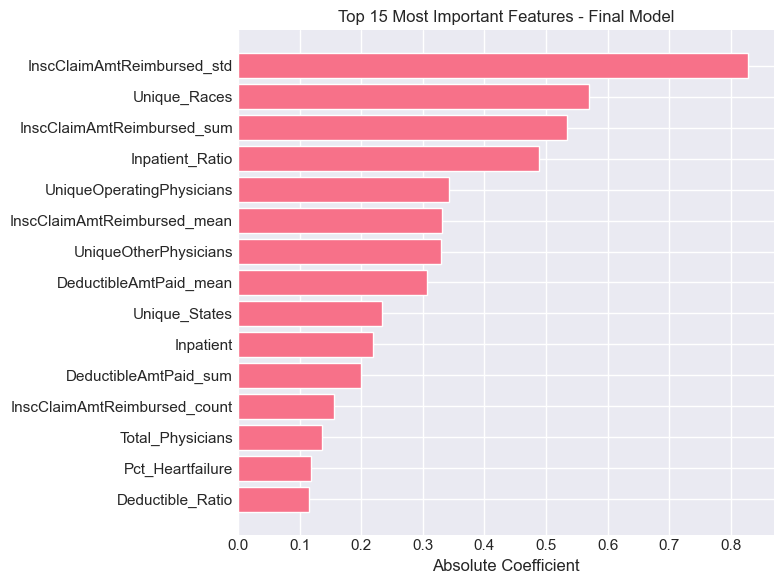

In [27]:
# %%
import numpy as np

if hasattr(best_model, "feature_importances_"):
    importance = best_model.feature_importances_
    importance_label = "Feature Importance"
else:
    # Logistic Regression: use absolute coefficient magnitude
    coefs = best_model.coef_[0]
    importance = np.abs(coefs)
    importance_label = "Absolute Coefficient"

# Top 15 most important features
sorted_idx = np.argsort(importance)[-15:]
top_features = np.array(feature_names)[sorted_idx]
top_importance = importance[sorted_idx]

plt.figure(figsize=(8, 6))
plt.barh(top_features, top_importance)
plt.title("Top 15 Most Important Features - Final Model")
plt.xlabel(importance_label)
plt.tight_layout()
plt.show()


In [28]:
# %%
if not hasattr(best_model, "feature_importances_"):
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": best_model.coef_[0]
    })
    coef_df["abs_coef"] = coef_df["coef"].abs()

    # Top 10 positive (increase fraud risk) and negative
    top_positive = coef_df.sort_values("coef", ascending=False).head(10)
    top_negative = coef_df.sort_values("coef", ascending=True).head(10)

    print("Top 10 features that INCREASE fraud probability:")
    display(top_positive)

    print("Top 10 features that DECREASE fraud probability:")
    display(top_negative)


Top 10 features that INCREASE fraud probability:


,feature,coef,abs_coef
2,InscClaimAmtReimbursed_std,0.828276,0.828276
17,Unique_Races,0.569603,0.569603
0,InscClaimAmtReimbursed_sum,0.533110,0.533110
11,Inpatient_Ratio,0.489262,0.489262
9,UniqueOperatingPhysicians,0.342174,0.342174
4,DeductibleAmtPaid_sum,0.199993,0.199993
3,InscClaimAmtReimbursed_count,0.156760,0.156760
12,Total_Physicians,0.136159,0.136159
15,Deductible_Ratio,0.115228,0.115228
16,Pct_Male,0.104933,0.104933


Top 10 features that DECREASE fraud probability:


,feature,coef,abs_coef
1,InscClaimAmtReimbursed_mean,-0.330446,0.330446
10,UniqueOtherPhysicians,-0.328848,0.328848
5,DeductibleAmtPaid_mean,-0.306729,0.306729
18,Unique_States,-0.234282,0.234282
6,Inpatient,-0.218825,0.218825
21,Pct_Heartfailure,-0.118596,0.118596
22,Pct_Diabetes,-0.005229,0.005229
14,Inpatient_Outpatient_Ratio,0.002800,0.002800
7,Outpatient,0.008072,0.008072
20,Pct_Alzheimer,0.014532,0.014532
